## High level notes

**Done**
- [x] add urls to svg to navigate back and forth between them
- [x] coherent results when nodes are clicked (display raw metrics)
- [x] add colors to facilitate analysis
- [x] add more relevant graphs for visualizing edges (e.g,. methods, successful, etc)

**Todo**
- [ ] convert code (use graphviz python library)

**Brainstorming**
- [ ] add toggles (e.g., show graphs for individual / group measures; product / cond / process; etc)
- [ ] add graphs (?) somewhere to summarize the data
- [ ] convert everything to D3 and make interactive graphs

## Libraries

In [1]:
# plotting using ggplot theme
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

In [2]:
import os
import subprocess
import collections
import pandas as pd

from IPython.display import SVG, display

In [3]:
# change working directory to more easily create links
if 'graphviz' in os.listdir('./'):
    os.chdir('./graphviz/')
    print("changed the root directory to ./graphviz")

changed the root directory to ./graphviz


## Get the data

In [4]:
def get_df(): 
    return pd.read_excel(open('../v20_long_data-BS.xlsx', 'rb'), sheet_name='long_data') 

In [5]:
df = get_df()
df.head()

,paper_id,metric_orig,metric_small,metric_large,metric_ig,outcome_orig,outcome_small,outcome_large,outcome_instrument,construct,construct_standardized,method,success_binary,year,field_author,field_paper
0,3,Focused gaze,Visual Attention,Gaze,individual,Program understanding,performance,product,researcher codes,group dynamics,group dynamics,glm,1,2013,MULTI,MULTI
1,3,Together gaze,Visual Attention,Gaze,group,Program understanding,performance,product,researcher codes,group dynamics,group dynamics,glm,1,2013,MULTI,MULTI
2,3,Focused gaze,Visual Attention,Gaze,individual,Dialogue episodes,coordination,process,researcher codes,group dynamics,group dynamics,glm,1,2013,MULTI,MULTI
3,3,Together gaze,Visual Attention,Gaze,group,Dialogue episodes,coordination,process,researcher codes,group dynamics,group dynamics,glm,1,2013,MULTI,MULTI
4,3,Gaze transitions,Eye Motion,Gaze,individual,Dialogue episodes,coordination,process,researcher codes,group dynamics,group dynamics,glm,1,2013,MULTI,MULTI


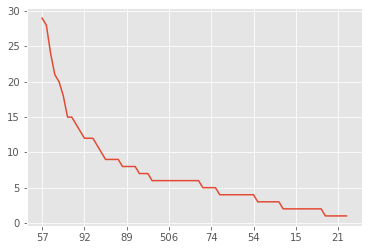

In [6]:
# distribution of links per paper
df.paper_id = df['paper_id'].astype(str)
df.paper_id.value_counts().plot()

In [7]:
# number of links with each method
df.method.value_counts()

glm                        170
sup. machine learning      164
correlation                144
unsup. machine learning     33
other                        4
Name: method, dtype: int64

In [8]:
# number of (un)successful links
df.success_binary.value_counts()

1    397
0    118
Name: success_binary, dtype: int64

In [9]:
df_meta = pd.read_excel(open('../v20_long_data-BS.xlsx', 'rb'), sheet_name='paper_meta') 

In [10]:
df_meta.head()

,paper_id,coder,omit_from_analysis,title,year,authors,paper link
0,1,bert,included,An Interactive Table for Supporting Participat...,2010,"Khaled Bachour, Frederic Kaplan, Pierre Dillen...",https://drive.google.com/file/d/1zxkGzpY9ZLWYP...
1,3,bert,included,Understanding collaborative program comprehens...,2013,"Kshitij Sharma, Patrick Jermann, Marc-Antoine ...",https://drive.google.com/file/d/12muYLYAqKPWJy...
2,4,edwin,included,Physiological Linkage of Dyadic Gaming Experience,2014,"Simo Järvelä, J. Matias Kivikangas, Jari Kätsy...",https://drive.google.com/file/d/1Twahp1Jbmszib...
3,5,iulian,included,A Multimodal-Sensor-Enabled Room for Unobtrusi...,2018,NaN,NaN
4,6,bert,included,Are we together or not? The temporal interplay...,2019,"Jonna Malmberm, Eetu Haataja, Tapio Seppänen, ...",NaN


## Display hierarchical graphs

**Done**
- [x] remove unsuccessful and duplicate links
- [x] add number of citations for each bubble 
- [x] put code into functions
- [x] change parameter to graph different levels
- [x] scale the size of the nodes and edges
- [x] make some comparisons between groups (e.g., individual vs group)
- [x] add unsuccessful connections as dotted lines
- [x] add method (somehow) to the link
- [x] ability to drill down
- [x] measures vs categories: different shapes (https://graphviz.org/doc/info/shapes.html)

**Todo**
- [ ] colors for product / process / group characteristics
- [ ] better rescale the node sizes (avoid huge nodes)

In [11]:
# colors
colors = ['gold','indianred1','skyblue','x11purple','springgreen4','deeppink']
colors = range(1,8)
metric_colors = dict(zip(list(set(df.metric_large)), colors))
print(metric_colors)

{'Physiological': 1, 'Body': 2, 'Verbal': 3, 'Log Data': 4, 'Gaze': 5, 'Head': 6}


In [12]:
# dictionary of metric types (for colors)
for index, row in df.iterrows():
    # add the metric categories
    if not row['metric_small'] in metric_colors.keys(): 
        if row['metric_large'] in metric_colors.keys():
            metric_colors[row['metric_small']] = metric_colors[row['metric_large']]
    # add the raw metrics
    if not row['metric_orig'] in metric_colors.keys(): 
        if row['metric_large'] in metric_colors.keys():
            metric_colors[row['metric_orig']] = metric_colors[row['metric_large']]

In [13]:
def preprocess_df(subset='all'):
    
    # get the data
    df = get_df()
    
    # select some rows
    if subset == 'individual': df = df[df.metric_ig == 'individual']
    if subset == 'group': df = df[df.metric_ig == 'group']
    
    # only keep one type of link per paper
    df.reset_index(drop=True, inplace=True) 
    df.drop_duplicates(inplace=True)
    
    # do some cleaning up
    df = df.replace({'interpersonal relationship / perception': 'interpersonal'})
    df = df.replace('"',' ', regex=True)
    
    return df

In [14]:
# get the different levels of our visualization
def get_levels(df, number=4): 
    levels = {}
    levels['metric_small'] = set(df.metric_small)
    if number > 3:
        levels['metric_large'] = set(df.metric_large)
    levels['outcome_small'] = set(df.outcome_large)
    if number > 2:
        levels['outcome_large'] = set(df.outcome_small)
    return levels

In [15]:
def get_counts(df, levels, successful=True, subgroup=None):

    link_counts = collections.defaultdict(lambda: 0)
    node_counts = collections.defaultdict(lambda: 0)

    # get the connections between the levels
    for index, row in df.iterrows():

        # go through the different levels
        for i,level in enumerate(levels.keys()): 
            
            # if we are looking at subgroups, we skip other outcomes
            if type(subgroup) != type(None) and row['outcome_large'] != subgroup: continue
                
            # this can be toggled to look at all vs successful relationships
            if successful:
                if row['success_binary'] == 0: continue

            # skip the first one
            if not i+1 < len(levels.keys()): continue

            # get the next level
            level2 = list(levels.keys())[i+1]

            # get the labels
            top = row[level]
            bottom = row[level2]

            # build the key
            key = '"' + top + '" -> "' + bottom + '"'
            link_counts[key] += 1
            node_counts[top] += 1
            node_counts[bottom] += 1
            
    return link_counts,node_counts

In [16]:
def get_shape(node, levels): 
    shapes = ['box', 'box3d', 'underline', 'note']
    shapes = ['plain', 'box', 'underline', 'box']
    shapes = ['plain', 'plain', 'plain', 'plain']
    for i,categories in enumerate(levels.values()):
        if node in categories:
            return shapes[i]
    else: return 'oval'

In [17]:
def add_legend(gv, df, metric_colors):
    # define the subgraph
    gv = '\n\t subgraph cluster_key{\n'
    gv += '\t\trankdir=RL;\n'
    gv += '\t\tlabel="Key";\n'
    
    # add all the nodes
    cat = list(set(df.metric_large))
    if "Log Data" in cat: cat.remove("Log Data")
    for small_metric in cat:
        if small_metric not in metric_colors.keys(): continue
        gv += '\t\t' + small_metric + 'bis [fontsize=40 style=filled fillcolor='+metric_colors[small_metric]+' label="'+small_metric+'"];\n'
    
    # add invisible connections (to make it horizontal)
    for i,small_metric in enumerate(cat):
        if i >= len(cat)-1: break
        gv += '\t\t' + small_metric + 'bis -> '+cat[i+1]+'bis [style=invis];\n'
    
    gv += '\t}\n\n'
    
    return gv

In [18]:
def generate_gv(levels, link_counts, node_counts, filename):
    gv = 'digraph world {\n\
    size="15,15";\n\
    rankdir=RL;\n\
    graph [fontname = "Times new roman"];\
    node [fontname = "Times new roman", colorscheme=set28];\
    edge [fontname = "Times new roman", colorscheme=set28];'
    
    
    # add the list of nodes
    min_font = min(node_counts.values())
    max_font = max(node_counts.values())
    for node,count in node_counts.items():
        if count == 0 or node == "other": continue
        
        # define the node parameters
        size = int(((count - min_font) / (max_font - min_font)) * 50) + 20
        fontsize = 'fontsize='+str(size)
        shape = 'shape='+get_shape(node, levels)
        tooltip = 'tooltip="'+str(count)+'"'
        url = 'href="'+node.replace(' ','_')+'.svg"'
        color = 'color="'+str(metric_colors[node]) + '"' if node in metric_colors.keys() else ""
        
        # put everything together and output the line
        parameters = ', '.join([shape,tooltip,fontsize,url,color])
        gv += '\t"'+node+'" ['+parameters+'];\n'
            
    gv += '\n\n'
        
    # add the levels
    for label,sublevels in levels.items():
        if "other" in sublevels: continue
        sublevels = [x for x in sublevels if node_counts[x] > 0]
        gv += '\t{rank=same; "'+ '" "'.join(sublevels) +'";}\n'

    gv += '\n\n'

    # output the links
    for connection,count in link_counts.items():
        if "other" in connection: continue
            
        # define the links parameters
        url = connection.replace('"','')+'.gv.svg'
        href = 'href="'+url+'"' if os.path.isfile(url) else 'href=""'
        tooltip = 'labeltooltip='+str(count)
        width = 'penwidth='+str(count/5)
        color = ''
        for node in metric_colors.keys():
            if node in connection: 
                color = 'color="'+str(metric_colors[node]) + '"'
            
        # put everything together
        parameters = ', '.join([tooltip,width,href,color])
        gv += '\t'+connection+' ['+parameters+'];\n'
        
    # add a legend at the top
    #gv += add_legend(gv, df, metric_colors)
    gv += '\n\n}'

    gv.replace('/', '-')

    # write the output
    with open(filename+'.gv', "w") as f: f.write(gv)

In [19]:
def generate_graph(filename):
    cmd = 'dot -Tsvg -l lib.ps '+filename+'.gv -o '+filename+'.svg'
    output = subprocess.check_output(cmd, shell=True)

In [20]:
def display_graph(output, subset='all', number=2, successful=False, subgroup=None): 
    ''' Putting it all together '''
    df = preprocess_df(subset=subset)
    levels = get_levels(df, number=number)
    link_counts,node_counts = get_counts(df, levels, successful=successful, subgroup=subgroup)
    generate_gv(levels, link_counts, node_counts, output)
    generate_graph(output)
    display(SVG(output+'.svg'))

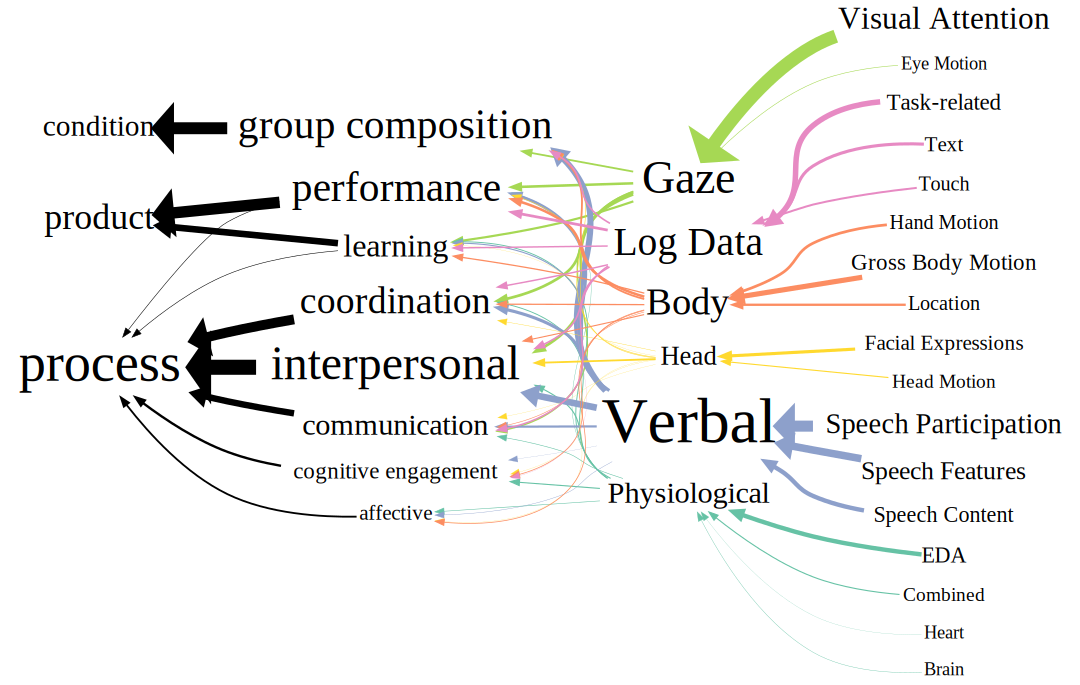

In [21]:
# display the process outcome
display_graph('index', successful=True, number=4)

## Display non hierarchical graphs

**Done**
- [x] create a graph for each outcome
- [x] create a graph for each metric
- [x] add link to come back to high-level graph

**Todo**
- [ ] group metrics together (+shorten them)
- [ ] add line thickness and node size

In [22]:
# for displaying purposes (on edges)
methods = {'correlation':'corr',
 'glm':'glm',
 'other':'',
 'sup. machine learning':'ml',
 'unsup. machine learning':'clust'}

In [23]:
def get_paper_link(paper_id, output='gscholar'):
    
    # if we use the paper name, we return a google scholar link
    if output == 'gscholar': 
        paper_name = str(df_meta[df_meta['paper_id'] == int(paper_id)]['title'].values[0])
        paper_name = paper_name.replace(' ', '%20')
        url = 'https://scholar.google.com/scholar?hl=en&q=' + paper_name
        return url
    
    # otherwise we return a (local) link to the pdf
    if output == 'pdf': 
        folder = '../../../Data/2021 - Round 4/'
        pdfs = os.listdir(folder)
        pdf = [x for x in pdfs if x.startswith('mmca'+str(int(paper_id)))]
        if len(pdf) < 1: return ''
        else: return os.path.join(folder,pdf[0])

In [24]:
def graph_outcome(subset, column='outcome_small', view=True):

    # get the data
    df = df = pd.read_excel(open('../v20_long_data-BS.xlsx', 'rb'), sheet_name='long_data') 
    df = df.replace({'interpersonal relationship / perception': 'interpersonal'})
    df = df.replace('"','', regex=True)
    
    # select some rows
    df = df[df[column] == subset]

    output = subset.replace(' ', '_')

    gv = 'digraph world {\n\
        size="15,15";\n\
        layout=neato\n\
        graph [fontname = "helvetica"];\n\
        node [fontname = "helvetica", colorscheme=set28];\n\
        edge [fontname = "helvetica", colorscheme=set28];\n\n'

    # define the node parameters
    gv += '\t"'+subset+'" [href="index.svg"];\n'
    for index,row in df.iterrows():
        node = row['metric_orig']
        #pdf = get_paper_link(int(row['paper_id']))
        pdf = get_paper_link(int(row['paper_id']))
        url = 'href="'+pdf+'"' + ' target="_blank" '
        color = 'color="'+str(int(metric_colors[node])) + '"' if node in metric_colors.keys() else ""
        parameters = ', '.join([url, color])
        gv += '\t"'+node+'" ['+parameters+'];\n'
    
    # get the connections 
    connections = collections.defaultdict(lambda: {})
    for index,row in df.iterrows():

        # get the labels
        top = row[column]
        bottom = row['metric_orig']
        style = 'solid' if row['success_binary'] > 0 else 'dotted'

        # build the key
        key = '"' + bottom + '" -> "' + top + '"'
        if not 'counts' in connections[key].keys(): 
            connections[key]['counts'] = 0
        connections[key]['counts'] += 1
        connections[key]['success'] = style
        connections[key]['method'] = methods[row['method']]
        
    # output the links
    for connection in connections.keys():
        if "other" in connection: continue
        count = connections[connection]['counts']
        style = connections[connection]['success']
        method = connections[connection]['method']
        gv += '\t'+connection+' [label="'+method+'", labeltooltip='+str(count)+', style="'+style+'", penwidth='+str(count)+'];\n'

    # add a legend at the top
    #gv += add_legend(gv, df, metric_colors)
    gv += '\n overlap=false \n splines = true; \n'
    gv += '\n\n}'

    gv.replace('/', '-')

    with open(output+'.gv', "w") as f: f.write(gv)

    cmd = 'dot -Tsvg -l lib.ps '+output+'.gv -o '+output+'.svg'
    print(output)
    subprocess.check_output(cmd, shell=True)
    if view: display(SVG(output+'.svg'))

performance
coordination
communication
affective
group_composition
interpersonal
cognitive_engagement
learning


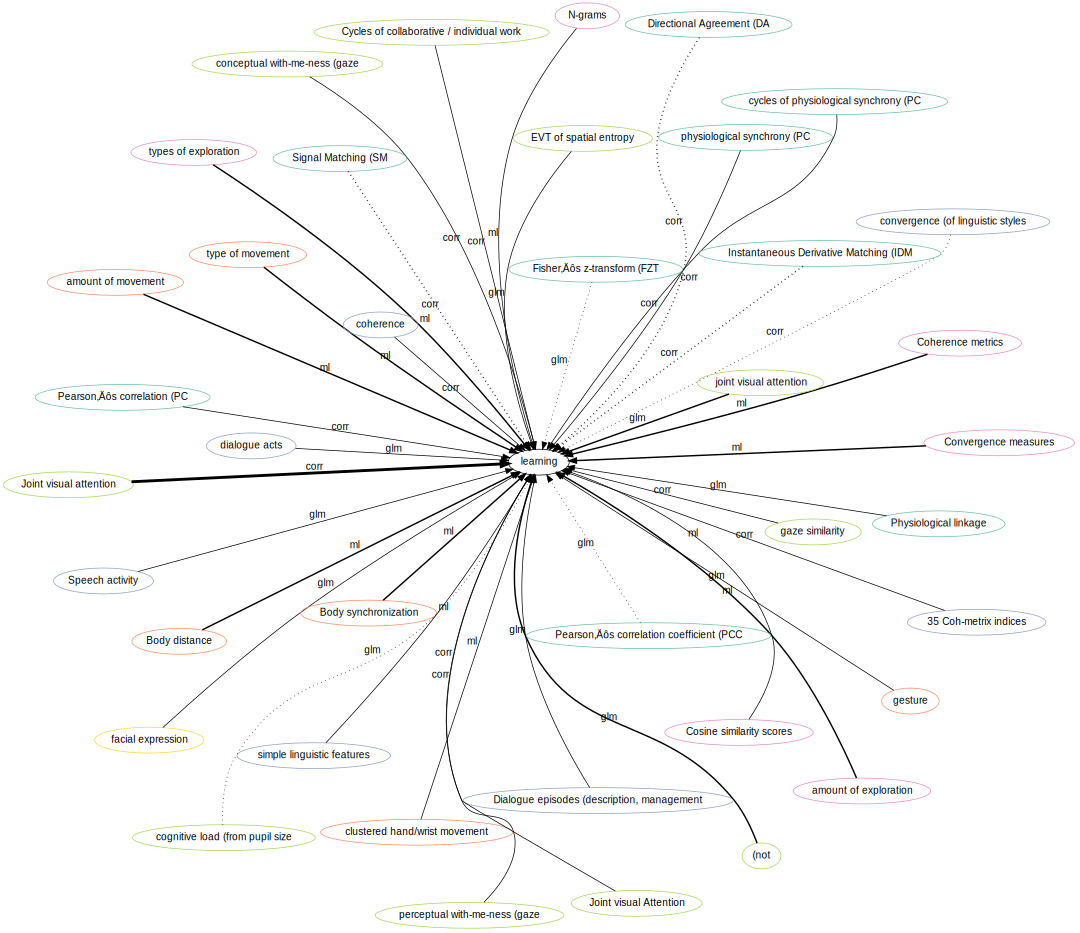

In [25]:
outcomes = list(set(get_df().outcome_small))

for i,outcome in enumerate(outcomes):
    
    # clean up
    if outcome == 'other': continue
    if outcome == 'interpersonal relationship / perception': outcome = 'interpersonal'
        
    # graph the outcome
    if i+1 == len(outcomes): graph_outcome(outcome, view=True)
    else: graph_outcome(outcome, view=False)

Location
Combined
Touch
Speech_Participation
Gross_Body_Motion
Task-related
Brain
EDA
Visual_Attention
Heart
Eye_Physiology
Hand_Motion
Eye_Motion
Text
Head_Motion
Speech_Features
Speech_Content
Facial_Expressions


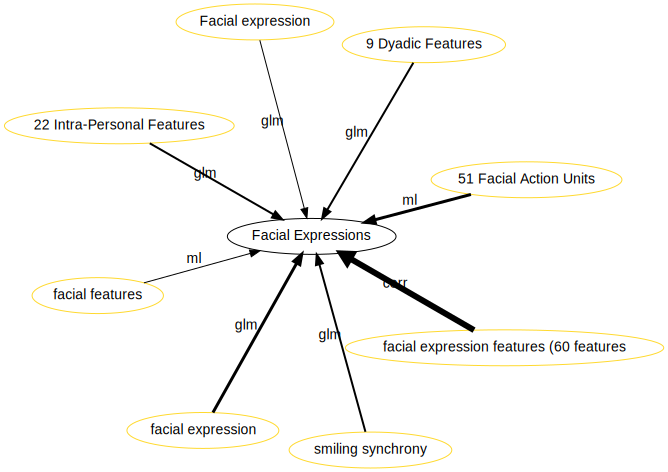

In [26]:
measures = list(set(get_df().metric_small))

for i,measure in enumerate(measures):
    if measure == 'other': continue
    if i+1 == len(measures): graph_outcome(measure, column='metric_small', view=True)
    else: graph_outcome(measure, column='metric_small', view=False)

Physiological
Body
Verbal
Log_Data
Gaze
Head


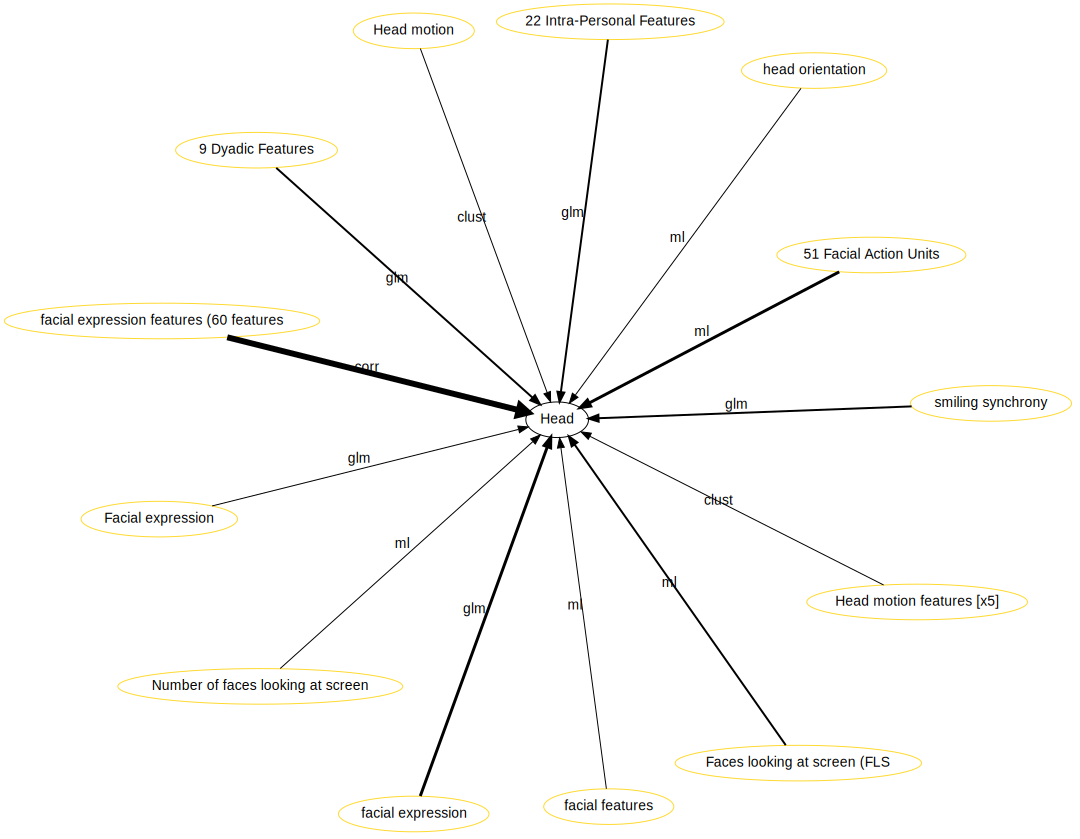

In [27]:
metrics = list(set(get_df().metric_large))

for i,metric in enumerate(metrics):
    if metric == 'other': continue
    if i+1 == len(metrics): graph_outcome(metric, column='metric_large', view=True)
    else: graph_outcome(metric, column='metric_large', view=False)

In [ ]:
outcomes = list(set(get_df().outcome_large))

for i,outcome in enumerate(outcomes):
    if measure == 'other': continue
    if i+1 == len(outcomes): graph_outcome(outcome, column='outcome_large', view=True)
    else: graph_outcome(outcome, column='outcome_large', view=False)

## Display original metrics / outcomes

### Testing out the python library

In [ ]:
import graphviz as pgv
from graphviz import Digraph

In [ ]:
# just running a simple example as a test
dot = Digraph(comment='The Round Table')
dot.node('A', 'King Arthur')
dot.node('B', 'Sir Bedevere the Wise')
dot.node('L', 'Sir Lancelot the Brave')
dot.edges(['AB', 'AL'])
dot.edge('B', 'L', constraint='false')
print(dot.source)

In [ ]:
dot.format = 'svg'
SVG(dot.render('test-round-table.gv', view=False))

### Displaying data from the dataframe

In [ ]:
df = preprocess_df()
df.head()

In [ ]:
def graph_outcome(outcome, metric):
    
    # define the graph
    dot = Digraph(name='Test')
    dot.format = 'svg'
    #dot.engine = 'circo'
    dot.attr(rankdir='RL')
    dot.attr(size='15,15')
    dot.attr(overlap='false')
    dot.attr(splines='true')
    
    # remove duplicate rows
    tmp = df[df.outcome_small == outcome]
    tmp = tmp[tmp.metric_large == metric]
    tmp = tmp[['paper_id','outcome_orig', 'metric_orig']]
    tmp.drop_duplicates(inplace=True)

    # align the metrics and outcomes
    metrics = '\t{rank=same; "' + '" "'.join(list(set(tmp.metric_orig))) + '";}'
    outcomes = '\t{rank=same; "' + '" "'.join(list(set(tmp.outcome_orig))) + '";}'
    dot.body.append(metrics)
    dot.body.append(outcomes)

    # iterate through the rows
    for index, row in tmp.iterrows():
        link = get_paper_link(row['paper_id'])
        pdf = get_paper_link(int(row['paper_id']))
        dot.node(str(row['metric_orig']), href=pdf)
        dot.edge(str(row['metric_orig']), str(row['outcome_orig']))

    # displays the last graph as an example
    return SVG(dot.render(metric+' -> '+outcome+'.gv', view=False))
 
# graph an example
graph_outcome('performance', 'Verbal')

In [ ]:
# iterate through the different outcomes we have
for outcome in set(df.outcome_small): 
    for metric in set(df.metric_large): 
        graph_outcome(outcome, metric)